# <a id="home">Chapter 2. End-to-End Machine Learning Project</a>

In this chapter you will work through an example project end to end, pretending to be a recently hired data scientist at a real estate company.     
Here are the main steps you will go through:    
1. [Look at the big picture](#look-at-the-big-picture).
2. [Get the data](#get-the-data).    
3. [Discover and visualize the data to gain insights](#discover-and-visualize-the-data).    
4. [Prepare the data for Machine Learning algorithms](#prepare-the-data).    
5. [Select a model and train it](#select-a-model).    
6. [Fine-tune your model](#fine-tune-your-model).    
7. [Present your solution](#present-your-solution).   
8. [Launch, monitor, and maintain your system](#launch-monitor).    

[Go to the last cell](#the-end)

## <a id="look-at-the-big-picture">Look at the Big Picture</a> (Back to [Home](#home))
Welcome to the Machine Learning Housing Corporation! Your first task is to use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will call them “districts” for short.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

<a id="setup"></a>
## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Frame the Problem
The first question to ask your boss is what exactly the business objective is. Building a model is probably not the end goal. How does the company expect to use and benefit from this model? Knowing the objective is important because it will determine how you frame the problem, which algorithms you will select, which performance measure you will use to evaluate your model, and how much effort you will spend tweaking it


Your boss answers that your model's output (a prediction of a district's median housing price) will be fed to another Machine Learning system (see Figure 2-2), along with many other signals.3 This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.    

![Hello](images/Figure2-2.png)

---
<div class="alert alert-block alert-info">
<b>Pipelines:</b> A sequence of data processing components is called a data pipeline. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply.

Components typically run asynchronously. Each component pulls in a large amount of data, processes it, and spits out the result in another data store. Then, some time later, the next component in the pipeline pulls this data and spits out its own output. Each component is fairly self-contained: the interface between components is simply the data store. This makes the system simple to grasp (with the help of a data flow graph), and different teams can focus on different components. Moreover, if a component breaks down, the downstream components can often continue to run normally (at least for a while) by just using the last output from the broken component. This makes the architecture quite robust.

On the other hand, a broken component can go unnoticed for some time if proper monitoring is not implemented. The data gets stale and the overall system’s performance drops.
</div>       
    
---    

The next question to ask your boss is what the current solution looks like (if any). The current situation will often give you a reference for performance, as well as insights on how to solve the problem. Your boss answers that the district housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district, and when they cannot get the median housing price, they estimate it using complex rules

This is costly and time-consuming, and their estimates are not great; in cases where they manage to find out the actual median housing price, they often realize that their estimates were off by more than 20%. This is why the company thinks that it would be useful to train a model to predict a district’s median housing price, given other data about that district. The census data looks like a great dataset to exploit for this purpose, since it includes the median housing prices of thousands of districts, as well as other data.

With all this information, you are now ready to start designing your system. First, you need to frame the problem: is it supervised, unsupervised, or Reinforcement Learning? Is it a classification task, a regression task, or something else? Should you use batch learning or online learning techniques? Before you read on, pause and try to answer these questions for yourself.

Have you found the answers? Let's see: it is clearly a typical supervised learning task, since you are given labeled training examples (each instance comes with the expected output, i.e., the district's median housing price). It is also a typical regression task, since you are asked to predict a value. More specifically, this is a multiple regression problem, since the system will use multiple features to make a prediction (it will use the district's population, the median income, etc.). It is also a univariate regression problem, since we are only trying to predict a single value for each district. If we were trying to predict multiple values per district, it would be a multivariate regression problem. Finally, there is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should do just fine.

## <a id="get-the-data">Get the data</a> (Back to [Home](#home))

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Let's take a look at the top five rows using the DataFrame's `head()` method.

In [4]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

The `info()` method is useful to get a quick description of the data, in particular the total number of rows, each attribute's type, and the number of nonnull values.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by Machine Learning standards, but it's perfect to get started. Notice that the total_bedrooms attribute has only 20,433 nonnull values, meaning that 207 districts are missing this feature. We will need to take care of this later.

All attributes are numerical, except the ocean_proximity field. Its type is object, so it could hold any kind of Python object. But since you loaded this data from a CSV file, you know that it must be a text attribute. When you looked at the top five rows, you probably noticed that the values in the ocean_proximity column were repetitive, which means that it is probably a categorical attribute. You can find out what categories exist and how many districts belong to each category by using the `value_counts()` method.

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let's look at the other fields. The `describe()` method shows a summary of the numerical attributes.

In [7]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

The `count`, `mean`, `min`, and `max` rows are self-explanatory. Note that the null values are ignored (so, for example, the count of total_bedrooms is 20,433, not 20,640). The `std` row shows the *standard deviation*, which measures how dispersed the values are. The 25%, 50%, and 75% rows show the corresponding *percentiles*: a percentile indicates the value below which a given percentage of observations in a group of observations fall. For example, 25% of the districts have a `housing_median_age` lower than 18, while 50% are lower than 29 and 75% are lower than 37. These are often called the 25th percentile (or first *quartile*), the median, and the 75th percentile (or third quartile).

Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). You can either plot this one attribute at a time, or you can call the `hist()` method on the whole dataset (as shown in the following code example), and it will plot a histogram for each numerical attribute:

Saving figure attribute_histogram_plots


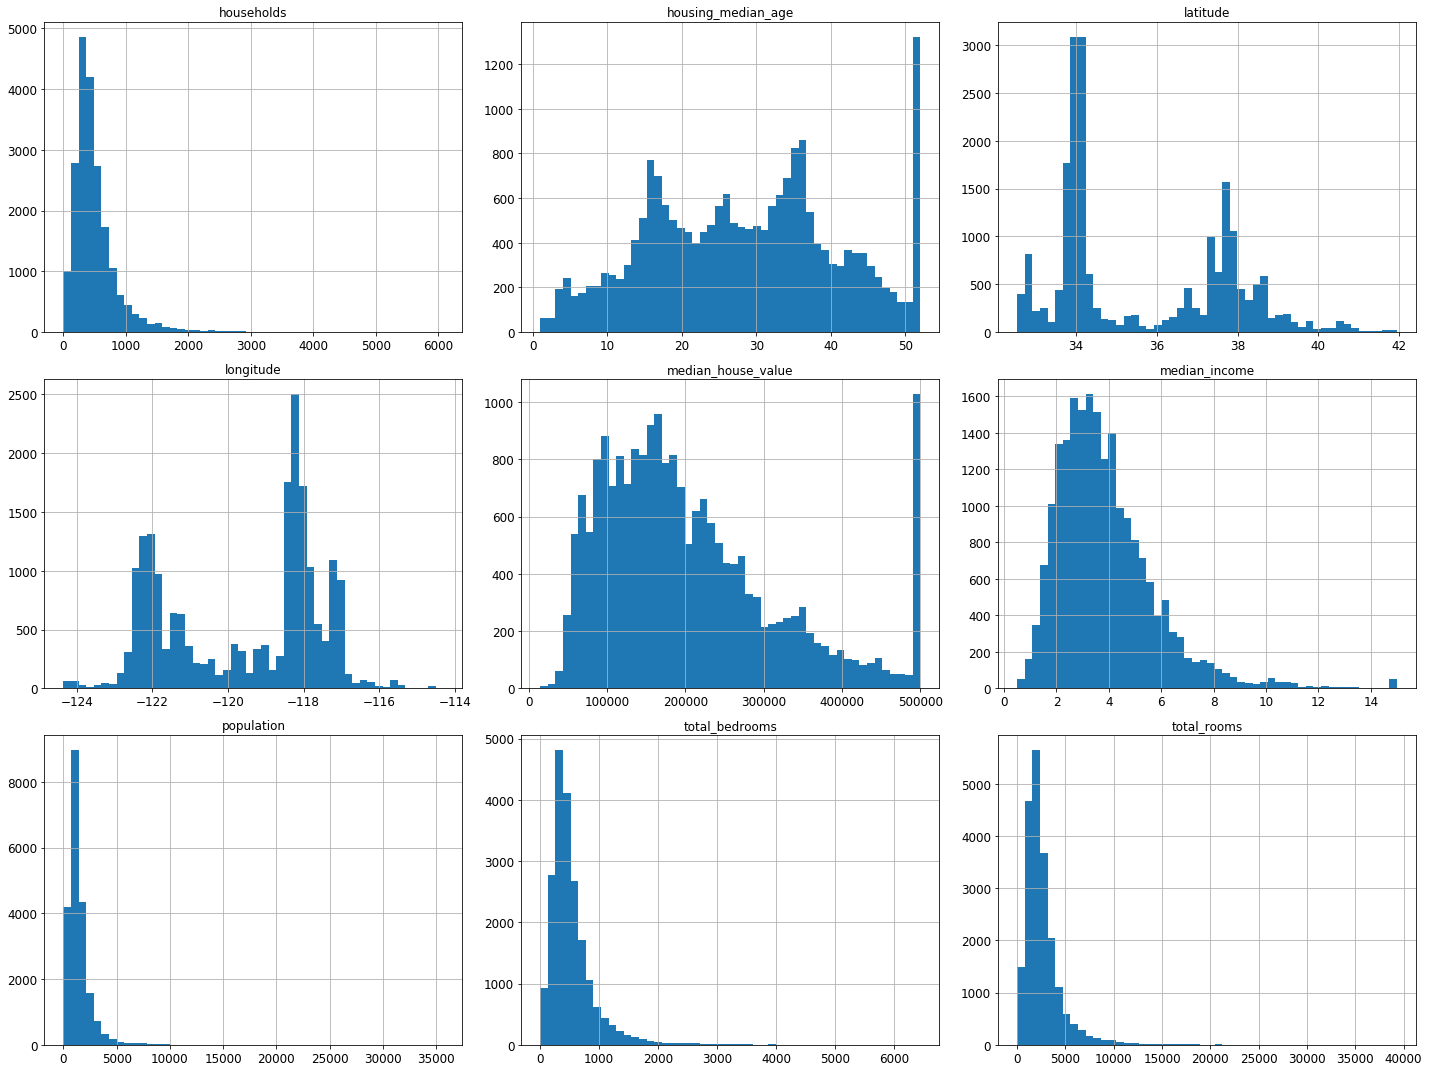

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

There are a few things you might notice in these histograms:
1.  First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about \\$30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.
2.  The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have two options:    
    a. Collect proper labels for the districts whose labels were capped.   
    b. Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond \\$500,000).
3. These attributes have very different scales. We will discuss this later in this chapter, when we explore feature scaling.
4. Finally, many histograms are *tail-heavy*: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

Hopefully you now have a better understanding of the kind of data you are dealing with.

---
<div class="alert alert-block alert-warning">
<b>Warning:</b> <br/>
Wait! Before you look at the data any further, you need to create a test set, put it aside, and never look at it.
</div>       
    
---    

## Create a Test Set
It may sound strange to voluntarily set aside part of the data at this stage. After all, you have only taken a quick glance at the data, and surely you should learn a whole lot more about it before you decide what algorithms to use, right? This is true, but your brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of Machine Learning model. When you estimate the generalization error using the test set, your estimate will be too optimistic, and you will launch a system that will not perform as well as expected. This is called *data snooping* bias.

Creating a test set is theoretically simple: pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside:

In [9]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [10]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [12]:
len(test_set)

4128

Well, this works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.

One solution is to save the test set on the first run and then load it in subsequent runs. Another option is to set the random number generator’s seed (e.g., with `np.random.seed(42)`) before calling `np.random.permutation()` so that it always generates the same shuffled indices.

But both these solutions will break the next time you fetch an updated dataset. To have a stable train/test split even after updating the dataset, a common solution is to use each instance's identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, you could compute a hash of each instance's identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.     
Here is a possible implementation:

In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID

In [14]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [15]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [16]:
test_set.head()

index  longitude  latitude  housing_median_age  total_rooms  \
59     59    -122.29     37.82                 2.0        158.0   
60     60    -122.29     37.83                52.0       1121.0   
61     61    -122.29     37.82                49.0        135.0   
62     62    -122.29     37.81                50.0        760.0   
67     67    -122.29     37.80                52.0       1027.0   

    total_bedrooms  population  households  median_income  median_house_value  \
59            43.0        94.0        57.0         2.5625             60000.0   
60           211.0       554.0       187.0         3.3929             75700.0   
61            29.0        86.0        23.0         6.1183             75000.0   
62           190.0       377.0       122.0         0.9011             86100.0   
67           244.0       492.0       147.0         2.6094             81300.0   

   ocean_proximity         id  
59        NEAR BAY -122252.18  
60        NEAR BAY -122252.17  
61        NEAR BAY -122252.18  
62        NEAR BAY -122252.19  
67        NEAR BAY -122252.20

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is `train_test_split()`, which does pretty much the same thing as the function `split_train_test()`, with a couple of additional features. First, there is a `random_state` parameter that allows you to set the random generator seed. Second, you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [18]:
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  
20046          INLAND  
3024           INLAND  
15663        NEAR BAY  
20484       <1H OCEAN  
9814       NEAR OCEAN

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. When a survey company decides to call 1,000 people to ask them a few questions, they don't just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is 51.3% females and 48.7% males, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called *stratified sampling*: the population is divided into homogeneous subgroups called *strata*, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. If the people running the survey used purely random sampling, there would be about a 12% chance of sampling a skewed test set that was either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased

Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely: most median income values are clustered around 1.5 to 6 (i.e., \\$15,000-\\$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum's importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the `pd.cut()` function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than \\$15,000), category 2 from 1.5 to 3, and so on:

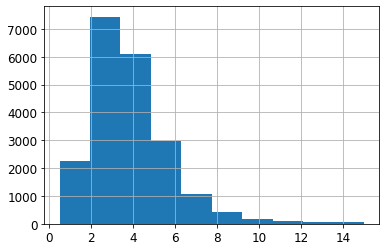

In [19]:
housing["median_income"].hist()

In [20]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [21]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

These income categories are represented:

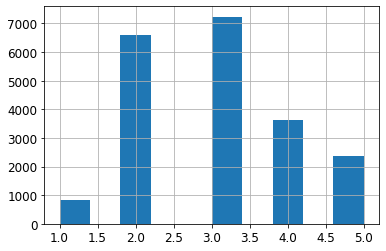

In [22]:
housing["income_cat"].hist()

Now you are ready to do stratified sampling based on the income category. For this you can use Scikit-Learn's `StratifiedShuffleSplit` class:

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's see if this worked as expected. You can start by looking at the income category proportions in the test set:

In [24]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

The income category proportions in the overall dataset is shown as follows:

In [25]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [26]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

With similar code you can measure the income category proportions in the full dataset. Table below compares the income category proportions in the overall dataset, in the test set generated with stratified sampling, and in a test set generated using purely random sampling. As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed

In [27]:
compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039729  0.040213      0.973236      -0.243309
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114583  0.109496     -4.318374       0.127011

Now you should remove the income_cat attribute so the data is back to its original state:

In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

We spent quite a bit of time on test set generation for a good reason: this is an often neglected but critical part of a Machine Learning project. Moreover, many of these ideas will be useful later when we discuss cross-validation. Now it's time to move on to the next stage: exploring the data.

## <a id="discover-and-visualize-the-data">Discover and visualize the data to gain insights</a> (Back to [Home](#home))

So far you have only taken a quick glance at the data to get a general understanding of the kind of data you are manipulating. Now the goal is to go into a little more depth.

First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small, so you can just work directly on the full set. Let's create a copy so that you can play with it without harming the training set:

In [29]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data:

Saving figure bad_visualization_plot


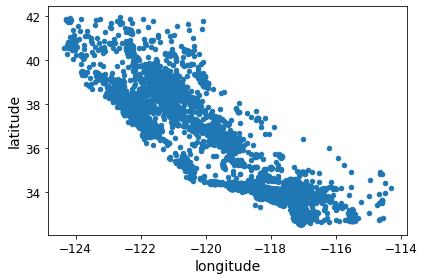

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

This looks like California all right, but other than that it is hard to see any particular pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points:

Saving figure better_visualization_plot


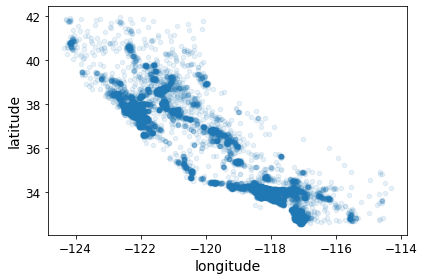

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Now that's much better: you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

Our brains are very good at spotting patterns in pictures, but you may need to play around with visualization parameters to make the patterns stand out.

Now let's look at the housing prices. The radius of each circle represents the district's population (option `s`), and the color represents the price (option `c`). We will use a predefined color map (option `cmap`) called `jet`, which ranges from blue (low values) to red (high prices):

Saving figure housing_prices_scatterplot


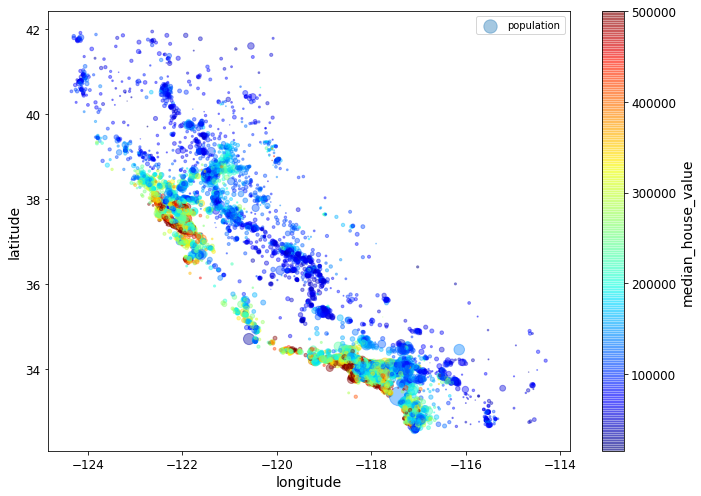

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

In [33]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7ff3c4eea610>)

Saving figure california_housing_prices_plot


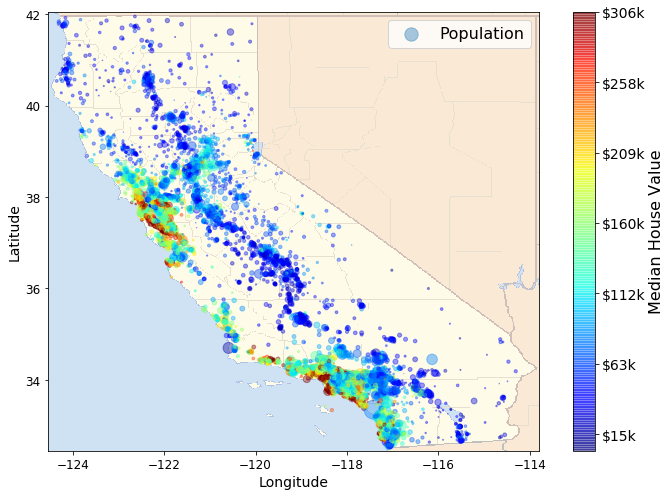

In [34]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### Looking for Correlations

Since the dataset is not too large, you can easily compute the _standard correlation coefficient_ (also called _Pearson's r_) between every pair of attributes using the `corr()` method:

In [35]:
corr_matrix = housing.corr()

In [36]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from -1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to -1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to 0 mean that there is no linear correlation. Figure 2-14 shows various plots along with the correlation coefficient between their horizontal and vertical axes.

![hello](images/Figure2-14.png)

<div class="alert alert-block alert-warning">
<b>Warning:</b> <br/> 
The correlation coefficient only measures linear correlations ("if x goes up, then y generally goes up/down"). It may completely miss out on nonlinear relationships (e.g., "if x is close to 0, then y generally goes up"). Note how all the plots of the bottom row have a correlation coefficient equal to 0, despite the fact that their axes are clearly not independent: these are examples of nonlinear relationships. Also, the second row shows examples where the correlation coefficient is equal to 1 or -1; notice that this has nothing to do with the slope. For example, your height in inches has a correlation coefficient of 1 with your height in feet or in nanometers.
</div>

Another way to check for correlation between attributes is to use the pandas `scatter_matrix()` function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get $11^2 = 121$ plots, which would not fit on a page; so let's just focus on a few promising attributes that seem most correlated with the median housing value:

Saving figure scatter_matrix_plot


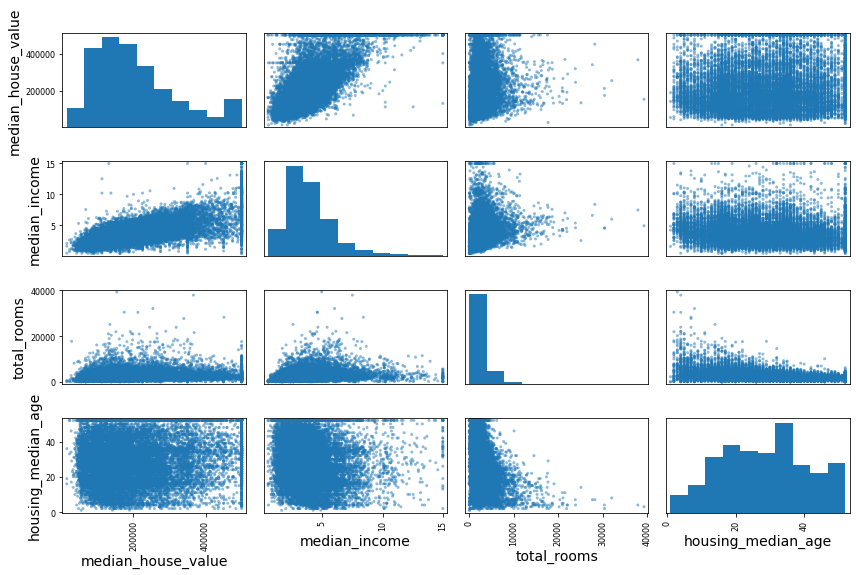

In [37]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

The main diagonal (top left to bottom right) would be full of straight lines if pandas plotted each variable against itself, which would not be very useful. So instead pandas displays a histogram of each attribute (other options are available; see the pandas documentation for more details).

The most promising attribute to predict the median house value is the median income, so let's zoom in on their correlation scatterplot:

Saving figure income_vs_house_value_scatterplot


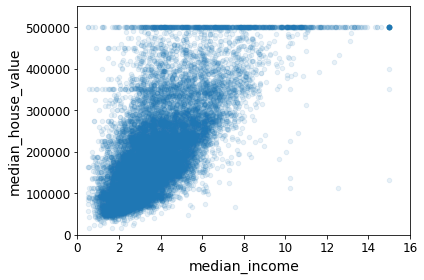

In [38]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

This plot reveals a few things.     
First, the correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed.     
Second, the price cap that we noticed earlier is clearly visible as a horizontal line at \\$500,000. But this plot reveals other less obvious straight lines: a horizontal line around \\$450,000, another around \\$350,000, perhaps one around \\$280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

### Experimenting with Attribute Combinations     
Hopefully the previous sections gave you an idea of a few ways you can explore the data and gain insights. You identified a few data quirks that you may want to clean up before feeding the data to a Machine Learning algorithm, and you found interesting correlations between attributes, in particular with the target attribute. You also noticed that some attributes have a tail-heavy distribution, so you may want to transform them (e.g., by computing their logarithm). Of course, your mileage will vary considerably with each project, but the general ideas are similar.

One last thing you may want to do before preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don't know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let's create these new attributes:

In [39]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [40]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Hey, not bad! The new `bedrooms_per_room` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district-obviously the larger the houses, the more expensive they are.

This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

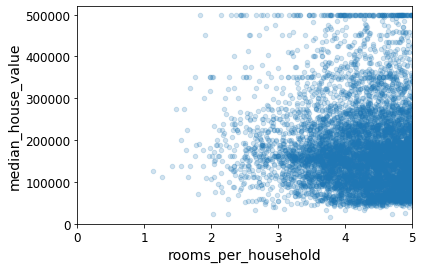

In [41]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [42]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.575834     35.639577           28.653101   2622.728319   
std        2.001860      2.138058           12.574726   2138.458419   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.500000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16354.000000  16512.000000  16512.000000   16512.000000   
mean       534.973890   1419.790819    497.060380       3.875589   
std        412.699041   1115.686241    375.720845       1.904950   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.000000    784.000000    279.000000       2.566775   
50%        433.000000   1164.000000    408.000000       3.540900   
75%        644.000000   1719.250000    602.000000       4.744475   
max       6210.000000  35682.000000   5358.000000      15.000100   

       median_house_value  rooms_per_household  bedrooms_per_room  \
count        16512.000000         16512.000000       16354.000000   
mean        206990.920724             5.440341           0.212878   
std         115703.014830             2.611712           0.057379   
min          14999.000000             1.130435           0.100000   
25%         119800.000000             4.442040           0.175304   
50%         179500.000000             5.232284           0.203031   
75%         263900.000000             6.056361           0.239831   
max         500001.000000           141.909091           1.000000   

       population_per_household  
count              16512.000000  
mean                   3.096437  
std                   11.584826  
min                    0.692308  
25%                    2.431287  
50%                    2.817653  
75%                    3.281420  
max                 1243.333333

## <a id="prepare-the-data">Prepare the data for Machine Learning algorithms</a> (Back to [Home](#home))

It's time to prepare the data for your Machine Learning algorithms. Instead of doing this manually, you should write functions for this purpose, for several good reasons:    
1.  This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).   
2.  You will gradually build a library of transformation functions that you can reuse in future projects.
3.  You can use these functions in your live system to transform the new data before feeding it to your algorithms.  
4.  This will make it possible for you to easily try various transformations and see which combination of transformations works best.

But first let's revert to a clean training set (by copying `strat_train_set` once again). Let's also separate the predictors and the labels, since we don't necessarily want to apply the same transformations to the predictors and the target values (note that `drop()` creates a copy of the data and does not affect `strat_train_set`):

In [43]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [44]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0             NaN   
6068     -117.86     34.01                16.0       4632.0             NaN   
17923    -121.97     37.35                30.0       1955.0             NaN   
13656    -117.30     34.05                 6.0       2155.0             NaN   
19252    -122.79     38.48                 7.0       6837.0             NaN   

       population  households  median_income ocean_proximity  
4629       3296.0      1462.0         2.2708       <1H OCEAN  
6068       3038.0       727.0         5.1762       <1H OCEAN  
17923       999.0       386.0         4.6328       <1H OCEAN  
13656      1039.0       391.0         1.6675          INLAND  
19252      3468.0      1405.0         3.1662       <1H OCEAN

### Data Cleaning
Most Machine Learning algorithms cannot work with missing features, so let's create a few functions to take care of them. We saw earlier that the total_bedrooms attribute has some missing values, so let's fix this. You have three options:
1.  Get rid of the corresponding districts.
2.  Get rid of the whole attribute.
3.  Set the values to some value (zero, the mean, the median, etc.).

You can accomplish these easily using DataFrame's `dropna()`, `drop()`, and `fillna()` methods:

In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

In [45]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [46]:
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   

       population  households  median_income ocean_proximity  
4629       3296.0      1462.0         2.2708       <1H OCEAN  
6068       3038.0       727.0         5.1762       <1H OCEAN  
17923       999.0       386.0         4.6328       <1H OCEAN  
13656      1039.0       391.0         1.6675          INLAND  
19252      3468.0      1405.0         3.1662       <1H OCEAN

If you choose option 3, you should compute the median value on the training set and use it to fill the missing values in the training set. Don't forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

Scikit-Learn provides a handy class to take care of missing values: `SimpleImputer`. Here is how to use it. First, you need to create a `SimpleImputer` instance, specifying that you want to replace each attribute's missing values with the median of that attribute:

In [47]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, you need to create a copy of the data without the text attribute `ocean_proximity`:

In [48]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

Now you can fit the imputer instance to the training data using the `fit()` method:

In [49]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

The `imputer` has simply computed the median of each attribute and stored the result in its `statistics_` instance variable. Only the `total_bedrooms` attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the `imputer` to all the numerical attributes:

In [50]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [51]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now you can use this "trained" imputer to transform the training set by replacing missing values with the learned medians:

In [52]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If you want to put it back into a pandas DataFrame, it's simple:

In [53]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

#### QUESTIONS:
Scikit-Learn's API is remarkably well designed.    
> **What are the main design principles?**


In [54]:
housing_tr.loc[sample_incomplete_rows.index.values]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   

       population  households  median_income  
4629       3296.0      1462.0         2.2708  
6068       3038.0       727.0         5.1762  
17923       999.0       386.0         4.6328  
13656      1039.0       391.0         1.6675  
19252      3468.0      1405.0         3.1662

In [55]:
imputer.strategy

'median'

In [56]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [57]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  
17606       710.0       339.0         2.7042  
18632       306.0       113.0         6.4214  
14650       936.0       462.0         2.8621  
3230       1460.0       353.0         1.8839  
3555       4459.0      1463.0         3.0347

### Handling Text and Categorical Attributes

So far we have only dealt with numerical attributes, but now let's look at text attributes. In this dataset, there is just one: the ocean_proximity attribute. Let's look at its value for the first 10 instances:

In [58]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

It's not arbitrary text: there are a limited number of possible values, each of which represents a category. So this attribute is a categorical attribute. Most Machine Learning algorithms prefer to work with numbers, so let's convert these categories from text to numbers. For this, we can use Scikit-Learn's `OrdinalEncoder` class:

In [59]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

You can get the list of categories using the `categories_` instance variable. It is a list containing a 1D array of categories for each categorical attribute (in this case, a list containing a single array since there is just one categorical attribute):

In [60]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as "bad," "average," "good," and "excellent"), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is "<1H OCEAN" (and 0 otherwise), another attribute equal to 1 when the category is "INLAND" (and 0 otherwise), and so on. This is called *one-hot encoding*, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called *dummy* attributes. Scikit-Learn provides a `OneHotEncoder` class to convert categorical values into one-hot vectors:

In [61]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

Notice that the output is a SciPy *sparse matrix*, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array, but if you really want to convert it to a (dense) NumPy array, just call the `toarray()` method

In [62]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [63]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [64]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers
Let's create a custom transformer to add extra attributes:

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, `add_bedrooms_per_room`, set to `True` by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

In [66]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
17606   -121.89    37.29                 38        1568            351   
18632   -121.93    37.05                 14         679            108   
14650    -117.2    32.77                 31        1952            471   
3230    -119.61    36.31                 25        1847            371   
3555    -118.59    34.23                 17        6592           1525   

      population households median_income ocean_proximity rooms_per_household  \
17606        710        339        2.7042       <1H OCEAN             4.62537   
18632        306        113        6.4214       <1H OCEAN             6.00885   
14650        936        462        2.8621      NEAR OCEAN             4.22511   
3230        1460        353        1.8839          INLAND             5.23229   
3555        4459       1463        3.0347       <1H OCEAN             4.50581   

      population_per_household  
17606                   2.0944  
18632                  2.70796  
14650                  2.02597  
3230                   4.13598  
3555                   3.04785

### Feature Scaling
One of the most important transformations you need to apply to your data is *feature scaling*. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: *min-max scaling* and *standardization*.

Min-max scaling (many people call this *normalization*) is the simplest: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called `MinMaxScaler` for this. It has a `feature_range` hyperparameter that lets you change the range if, for some reason, you don’t want 0-1.

Standardization is different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0-15 down to 0-0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called `StandardScaler` for standardization.

---
<div class="alert alert-block alert-warning">
<b>Warning:</b> As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).
</div>       
    
---    

### Transformation Pipelines
Now let's build a pipeline for preprocessing the numerical attributes:

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [68]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a `fit_transform()` method). The names can be anything you like (as long as they are unique and don’t contain double underscores, \__); they will come in handy later for hyperparameter tuning.

When you call the pipeline's `fit()` method, it calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it calls the `fit()` method.

The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a `StandardScaler`, which is a transformer, so the pipeline has a `transform()` method that applies all the transforms to the data in sequence (and of course also a `fit_transform()` method, which is the one we used).

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column. In version 0.20, Scikit-Learn introduced the `ColumnTransformer` for this purpose, and the good news is that it works great with pandas DataFrames. Let's use it to apply all the transformations to the housing data:

In [69]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [70]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [71]:
housing_prepared.shape

(16512, 16)

First we import the `ColumnTransformer` class, next we get the list of numerical column names and the list of categorical column names, and then we construct a `ColumnTransformer`. The constructor requires a list of tuples, where each tuple contains a name, a transformer, and a list of names (or indices) of columns that the transformer should be applied to. In this example, we specify that the numerical columns should be transformed using the `num_pipeline` that we defined earlier, and the categorical columns should be transformed using a `OneHotEncoder`. Finally, we apply this `ColumnTransformer` to the housing data: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

Note that the `OneHotEncoder` returns a sparse matrix, while the num_pipeline returns a dense matrix. When there is such a mix of sparse and dense matrices, the `ColumnTransformer` estimates the density of the final matrix (i.e., the ratio of nonzero cells), and it returns a sparse matrix if the density is lower than a given threshold (by default, `sparse_threshold=0.3`). In this example, it returns a dense matrix. And that's it! We have a preprocessing pipeline that takes the full housing data and applies the appropriate transformations to each column.

## <a id="select-a-model">Select and train a model</a> (Back to [Home](#home))
At last! You framed the problem, you got the data and explored it, you sampled a training set and a test set, and you wrote transformation pipelines to clean up and prepare your data for Machine Learning algorithms automatically. You are now ready to select and train a Machine Learning model.

### Training and Evaluating on the Training Set
The good news is that thanks to all these previous steps, things are now going to be much simpler than you might think. Let’s first train a Linear Regression model, like we did in the previous chapter:

In [72]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Done! You now have a working Linear Regression model. Let's try it out on a few instances from the training set:

In [73]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Compare against the actual values:

In [74]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [75]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

It works, although the predictions are not exactly accurate (e.g., the first prediction is off by close to 40%!). Let's measure this regression model's RMSE on the whole training set using Scikit-Learn's `mean_squared_error()` function:

In [76]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

Also, we can use `mean_absolute_error` function as follows: 

In [77]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001898

Let's train a `DecisionTreeRegressor`. This is a powerful model, capable of finding complex nonlinear relationships in the data (Decision Trees are presented in more detail in Chapter 6). The code should look familiar by now:

In [78]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Now that the model is trained, let's evaluate it on the training set:

In [79]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure? As we saw earlier, you don't want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

### Better Evaluation Using Cross-Validation
One way to evaluate the Decision Tree model would be to use the `train_test_split()` function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It's a bit of work, but nothing too difficult, and it would work fairly well.

A great alternative is to use Scikit-Learn's *K-fold cross-validation* feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [80]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

---
<div class="alert alert-block alert-warning">
<b>Warning:</b> Scikit-Learn's cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes `-scores` before calculating the square root.
</div>       
    
---    

In [81]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


Now the Decision Tree doesn't look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately $71,407$, generally $\pm2,439$. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

Let's compute the same scores for the Linear Regression model just to be sure:

In [82]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68024.01273425 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69051.74924793819
Standard deviation: 2731.941072269529


**Note**: we specify `n_estimators=100` to be future-proof since the default value is going to change to 100 in Scikit-Learn 0.22 (for simplicity, this is not shown in the book).

That's right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

Let's try one last model now: the `RandomForestRegressor`. As we will see in Chapter 7, Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called *Ensemble Learning*, and it is often a great way to push ML algorithms even further. We will skip most of the code since it is essentially the same as for the other models:

In [83]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [84]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

Wow, this is much better: Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. Before you dive much deeper into Random Forests, however, you should try out many other models from various categories of Machine Learning algorithms (e.g., several Support Vector Machines with different kernels, and possibly a neural network), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

---
<div class="alert alert-block alert-info">
<b>Tip:</b> You should save every model you experiment with so that you can come back easily to any model you want. Make sure you save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to easily compare scores across model types, and compare the types of errors they make. You can easily save Scikit-Learn models by using Python's `pickle` module or by using the `joblib` library, which is more efficient at serializing large NumPy arrays (you can install this library using pip):
</div>       

`import joblib`        
`joblib.dump(my_model, "my_model.pkl")`    
`# and later ...`    
`my_model_loaded = joblib.load("my_model.pkl")`    

---    

In [85]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [86]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69051.749248
std       2879.718741
min      64969.630564
25%      67136.363758
50%      68152.812057
75%      70982.369487
max      74739.570526
dtype: float64

In [87]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

#### TASK:
Try to utilize *cross-validation* for `svm_reg` and display the scores.

## <a id="fine-tune-your-model">Fine-tune Your Model</a> (Back to [Home](#home))

Let's assume that you now have a shortlist of promising models. You now need to fine-tune them. Let's look at a few ways you can do that.

#### Grid Search
One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead, you should get Scikit-Learn's `GridSearchCV` to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. For example, the following code searches for the best combination of hyperparameter values for the `RandomForestRegressor`:

In [88]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

This param_grid tells Scikit-Learn to first evaluate all $3 \times 4 = 12$ combinations of `n_estimators` and `max_features` hyperparameter values specified in the first `dict` (don't worry about what these hyperparameters mean for now; they will be explained in Chapter 7), then try all $2 \times 3 = 6$ combinations of hyperparameter values in the second `dict`, but this time with the `bootstrap` hyperparameter set to `False` instead of `True` (which is the default value for this hyperparameter).

The grid search will explore $12 + 6 = 18$ combinations of `RandomForestRegressor` hyperparameter values, and it will train each model $5$ times (since we are using five-fold cross validation). In other words, all in all, there will be $18 \times 5 = 90$ rounds of training! It may take quite a long time, but when it is done you can get the best combination of parameters like this:

The best hyperparameter combination found:

In [89]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [90]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [91]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [92]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.153278      0.004841         0.006791        0.000044   
1        0.501051      0.006783         0.019410        0.001126   
2        1.496984      0.014169         0.052926        0.000328   
3        0.248856      0.002861         0.006852        0.000068   
4        0.814079      0.004602         0.018880        0.000173   
5        2.435558      0.015519         0.052903        0.000251   
6        0.335502      0.009294         0.006798        0.000013   
7        1.138497      0.030594         0.018872        0.000260   
8        3.408797      0.019919         0.053767        0.000555   
9        0.429042      0.003784         0.006770        0.000018   
10       1.453521      0.024045         0.019095        0.000700   
11       4.432474      0.047630         0.055462        0.002361   
12       0.243410      0.007674         0.007769        0.000276   
13       0.855628      0.040689         0.023579        0.000932   
14       0.355646      0.013885         0.008642        0.000493   
15       1.107418      0.036288         0.023111        0.001447   
16       0.406349      0.006605         0.007848        0.000190   
17       1.356821      0.016911         0.022080        0.000650   

   param_max_features param_n_estimators param_bootstrap  \
0                   2                  3             NaN   
1                   2                 10             NaN   
2                   2                 30             NaN   
3                   4                  3             NaN   
4                   4                 10             NaN   
5                   4                 30             NaN   
6                   6                  3             NaN   
7                   6                 10             NaN   
8                   6                 30             NaN   
9                   8                  3             NaN   
10                  8                 10             NaN   
11                  8                 30             NaN   
12                  2                  3           False   
13                  2                 10           False   
14                  3                  3           False   
15                  3                 10           False   
16                  4                  3           False   
17                  4                 10           False   

                                               params  split0_test_score  \
0              {'max_features': 2, 'n_estimators': 3}      -3.837622e+09   
1             {'max_features': 2, 'n_estimators': 10}      -3.047771e+09   
2             {'max_features': 2, 'n_estimators': 30}      -2.689185e+09   
3              {'max_features': 4, 'n_estimators': 3}      -3.730181e+09   
4             {'max_features': 4, 'n_estimators': 10}      -2.666283e+09   
5             {'max_features': 4, 'n_estimators': 30}      -2.387153e+09   
6              {'max_features': 6, 'n_estimators': 3}      -3.119657e+09   
7             {'max_features': 6, 'n_estimators': 10}      -2.549663e+09   
8             {'max_features': 6, 'n_estimators': 30}      -2.370010e+09   
9              {'max_features': 8, 'n_estimators': 3}      -3.353504e+09   
10            {'max_features': 8, 'n_estimators': 10}      -2.571970e+09   
11            {'max_features': 8, 'n_estimators': 30}      -2.357390e+09   
12  {'bootstrap': False, 'max_features': 2, 'n_est...      -3.785816e+09   
13  {'bootstrap': False, 'max_features': 2, 'n_est...      -2.810721e+09   
14  {'bootstrap': False, 'max_features': 3, 'n_est...      -3.618324e+09   
15  {'bootstrap': False, 'max_features': 3, 'n_est...      -2.757999e+09   
16  {'bootstrap': False, 'max_features': 4, 'n_est...      -3.134040e+09   
17  {'bootstrap': False, 'max_features': 4, 'n_est...      -2.525578e+09   

    split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0       -4.147108e+09  ...    -4.053756e+09  

In this example, we obtain the best solution by setting the `max_features` hyperparameter to $8$ and the `n_estimators` hyperparameter to $30$. The RMSE score for this combination is $49,682$, which is slightly better than the score you got earlier using the default hyperparameter values (which was $50,182$). Congratulations, you have successfully fine-tuned your best model!

### Randomized Search
The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use `RandomizedSearchCV` instead. This class can be used in much the same way as the `GridSearchCV` class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
1.  If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach)
2.  Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.

### Ensemble Methods
Another way to fine-tune your system is to try to combine the models that perform best. The group (or "ensemble") will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different types of errors. We will cover this topic in more detail in Chapter 7.

### Analyze the Best Models and Their Errors
You will often gain good insights on the problem by inspecting the best models. For example, the `RandomForestRegressor` can indicate the relative importance of each attribute for making accurate predictions:

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [94]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [95]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

Let's display these importance scores next to their corresponding attribute names:

In [96]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).

### Evaluate Your System on the Test Set
After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your `full_pipeline` to transform the data (call `transform()`, *not* `fit_transform()`; you do not want to fit the test set!), and evaluate the final model on the test set:

In [97]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [98]:
final_rmse

47730.22690385927

In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just 0.1% better than the model currently in production? You might want to have an idea of how precise this estimate is. For this, you can compute a 95% *confidence interval* for the generalization error using `scipy.stats.t.interval()`:

We can compute a 95% confidence interval for the test RMSE:

In [99]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

We could compute the interval manually like this:

In [100]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

Alternatively, we could use a z-scores rather than t-scores:

In [101]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

If you did a lot of hyperparameter tuning, the performance will usually be slightly worse than what you measured using cross-validation (because your system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

## <a id="present-your-solution">Present Your Solution</a> (Back to [Home](#home))
Now comes the project prelaunch phase: you need to present your solution (highlighting what you have learned, what worked and what did not, what assumptions were made, and what your system's limitations are), document everything, and create nice presentations with clear visualizations and easy-to-remember statements (e.g., "the median income is the number one predictor of housing prices"). In this California housing example, the final performance of the system is not better than the experts' price estimates, which were often off by about 20%, but it may still be a good idea to launch it, especially if this frees up some time for the experts so they can work on more interesting and productive tasks.

## <a id="launch-monitor">Launch, Monitor, and Maintain Your System</a> (Back to [Home](#home))
Perfect, you got approval to launch! You now need to get your solution ready for production (e.g., polish the code, write documentation and tests, and so on). Then you can deploy your model to your production environment. One way to do this is to save the trained Scikit-Learn model (e.g., using `joblib`), including the full preprocessing and prediction pipeline, then load this trained model within your production environment and use it to make predictions by calling its `predict()` method. For example, perhaps the model will be used within a website: the user will type in some data about a new district and click the Estimate Price button. This will send a query containing the data to the web server, which will forward it to your web application, and finally your code will simply call the model’s `predict()` method (you want to load the model upon server startup, rather than every time the model is used). Alternatively, you can wrap the model within a dedicated web service that your web application can query through a REST API (see Figure 2-17). This makes it easier to upgrade your model to new versions without interrupting the main application. It also simplifies scaling, since you can start as many web services as needed and load-balance the requests coming from your web application across these web services. Moreover, it allows your web application to use any language, not just Python.     
![Hello](images/Figure2-17.png)


# Extra material

## A full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

## Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

Congratulations! You already know quite a lot about Machine Learning. :)

## <a id="the-end">The End</a> (Back to [Home](#home))